In [1]:
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random
import collections
import matplotlib.pyplot as plt
from data_augmentation import build_balanced_augmented_tensor_dataset

In [2]:
# riproducibilità
random.seed(42)
torch.manual_seed(42)

In [3]:
# CONFIGURAZIONE
base_dir = os.getcwd()
image_size = 224
batch_size = 32
n_components = 146
# 3, 8, 17, 40, 146
# dimensioni su cui vogliamo fare PCA, trovate con explained variance 
# e selezionado le soglie = [0.95, 0.85, 0.75, 0.65, 0.50]
epochs = 20
output_folder = os.path.join(base_dir, "pca_outputs")
save_path = os.path.join(output_folder, f'pca_data_{n_components}_augmented.pth')
pretty_labels = ['Adenocarcinoma', 'Large Cell', 'Normal', 'Squamous Cell']

In [4]:
# TRASFORMAZIONI BASE
base_transform = transforms.Resize((image_size, image_size))
tensor_transform = transforms.ToTensor()

# Val/test con trasformazione base
transform_val_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])


In [5]:
# DATASET
paths = {
    'train': os.path.join(base_dir, 'data_images', 'train'),
    'val': os.path.join(base_dir, 'data_images', 'valid'),
    'test': os.path.join(base_dir, 'data_images', 'test')
}

In [6]:
datasets_dict = {
    'val': datasets.ImageFolder(paths['val'], transform=transform_val_test),
    'test': datasets.ImageFolder(paths['test'], transform=transform_val_test)
}

In [7]:
train_imgs, train_labels, class_names = build_balanced_augmented_tensor_dataset(
    os.path.join(base_dir, 'data_images', 'train'),
    image_size=224,
    mode='augment',
    augment_factor=10,
    binary=True  # 🔁 Attiva classificazione binaria
)


train_data = train_imgs.view(train_imgs.size(0), -1).numpy()

In [8]:
# DATALOADERS
loaders = {k: DataLoader(datasets_dict[k], batch_size=batch_size, shuffle=False) for k in ['val', 'test']}

In [9]:
# ESTRAZIONE
def extract_data(loader):
    data, labels = [], []
    for images, targets in tqdm(loader, desc="Estrazione dati"):
        flat = images.view(images.size(0), -1)
        data.append(flat)
        labels.append(targets)
    data = torch.cat(data, dim=0).numpy()
    labels = torch.cat(labels).numpy()
    return data, labels

val_data, val_labels = extract_data(loaders['val'])
test_data, test_labels = extract_data(loaders['test'])

Estrazione dati:   0%|          | 0/3 [00:00<?, ?it/s]

Estrazione dati: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


In [10]:
# NORMALIZZAZIONE
min_val = train_data.min()
max_val = train_data.max()

def normalize(data):
    return np.clip((data - min_val) / (max_val - min_val), 0, 1)

train_data = normalize(train_data)
val_data = normalize(val_data)
test_data = normalize(test_data)

In [11]:
# PCA
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(train_data)
val_pca = pca.transform(val_data)
test_pca = pca.transform(test_data)

In [12]:
# SALVA DATI
torch.save({
    'train_data': train_pca,
    'val_data': val_pca,
    'test_data': test_pca,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'class_names': pretty_labels
}, save_path)
print(f"Dati salvati in {save_path}")

Dati salvati in c:\Users\noemi\Documents\GitHub\DAML-project\pca_outputs\pca_data_146_augmented.pth


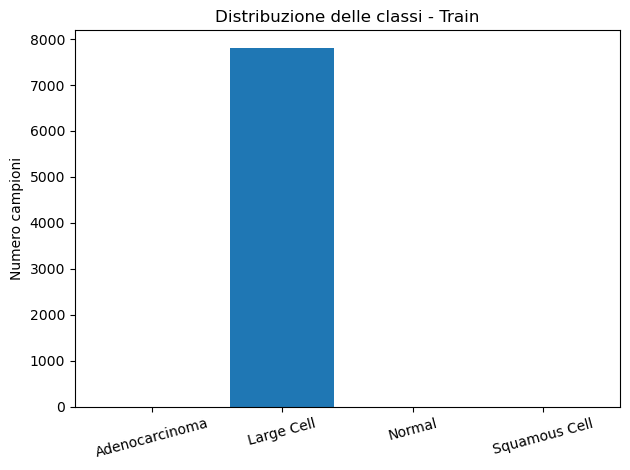

In [13]:
label_counts = collections.Counter(train_labels.tolist())
plt.bar(pretty_labels, [label_counts.get(i, 0) for i in range(len(pretty_labels))])
plt.title("Distribuzione delle classi - Train")
plt.xticks(rotation=15)
plt.ylabel("Numero campioni")
plt.tight_layout()
plt.show()


In [14]:
print(f"Numero :{len(train_labels)}")

Numero :7800
